# Continous Frugal Flows

In this notebook we demonstrate the ability for Frugal Flows to identify Marginal Causal Effects

In [1]:
import sys
import os
sys.path.append("../") # go to parent dir

import jax
import jax.random as jr
import jax.numpy as jnp
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import scipy
import numpy as np
from scipy.stats import rankdata
import scipy.stats as ss
import statsmodels.api as sm
import seaborn as sns
from sklearn.model_selection import KFold

# from data.create_sim_data import *
import data.template_causl_simulations as causl_py
from data.run_all_simulations import plot_simulation_results
from frugal_flows.causal_flows import independent_continuous_marginal_flow, get_independent_quantiles, train_frugal_flow
from frugal_flows.bijections import UnivariateNormalCDF

import rpy2.robjects as ro
from rpy2.robjects.packages import importr
from rpy2.robjects import pandas2ri
from rpy2.robjects.packages import SignatureTranslatedAnonymousPackage

# Activate automatic conversion of rpy2 objects to pandas objects
pandas2ri.activate()

# Import the R library causl
try:
    causl = importr('causl')
except Exception as e:
    package_names = ('causl')
    utils.install_packages(StrVector(package_names))

jax.config.update("jax_enable_x64", True)

hyperparams_dict = {
    'learning_rate': 5e-3,
    'RQS_knots': 8,
    'flow_layers': 5,
    'nn_width': 30,
    'nn_depth': 4,    
    'max_patience': 50,
    'max_epochs': 10000
}
causal_hyperparams = {
    'RQS_knots': 8,
    'flow_layers': 5,
    'nn_width': 50,
    'nn_depth': 4,   
}

SEED = 0
NUM_ITER = 10
NUM_SAMPLES = 10000
TRUE_PARAMS = {'ate': 1, 'const': 1, 'scale': 1}
CAUSAL_PARAMS = [1, 1]

In [2]:
def run_outcome_regression(data):
    df = pd.DataFrame(jnp.hstack([data['Y'], data['X']]), columns=['X', 'Y'])
    df['X'] = data['X']
    df['Y'] = data['Y']
    X_vars = df['X']
    X_vars = sm.add_constant(X_vars)
    Y_var = df['Y']
    model = sm.OLS(Y_var, X_vars).fit()
    coefficient_X = model.params['X']
    coefficient_const = model.params['const']
    return coefficient_X, coefficient_const

In [3]:
CAUSAL_PARAMS = [1, 1]
SEED = 123
Z_d, Z_c, X, Y = causl_py.generate_mixed_samples(N=10000, causal_params=CAUSAL_PARAMS, seed=SEED).values()

uz_samples = causl_py.generate_uz_samples(Z_cont=Z_c, use_marginal_flow=False)

ff, _ = train_frugal_flow(
    key=jr.PRNGKey(1),
    y=Y,
    u_z=uz_samples['uz_cont'],
    condition=X,
    **hyperparams_dict,
    causal_model_args={'ate': 0, 'const': 0, 'scale': 1}
)

causal_margin = ff.bijection.bijections[-1].bijection.bijections[0]

print(causal_margin.ate)
print(causal_margin.const)

  1%|▉                                                                                                 | 97/10000 [00:41<1:10:46,  2.33it/s, train=1.308586016373885, val=1.3819704980468446 (Max patience reached)]

0.9557490535363774
1.0292848403054966


## Checking for the Causal Effect

### Gaussians

#### Frugal Flow

In [4]:
gaussian_covariates_results = causl_py.run_simulations(
    causl_py.generate_gaussian_samples, 
    seed=SEED, 
    num_samples=NUM_SAMPLES, 
    num_iter=NUM_ITER, 
    causal_params=CAUSAL_PARAMS,
    hyperparams_dict=hyperparams_dict,
    causal_model_args={'ate': 0., 'const': 0., 'scale': 1}
)

  1%|▋                                                                                               | 76/10000 [00:32<1:11:26,  2.32it/s, train=-1.631032074728313, val=-1.5481476763473099 (Max patience reached)]


In [5]:
gaussian_covariates_results

,ate,const,scale
0,1.001427,0.992398,1.010613
1,0.969419,1.026160,1.014438
2,1.002122,0.992484,1.026100
3,1.011173,1.009542,1.015836
4,1.017371,0.996287,0.996285
5,0.989980,0.993496,1.017365
6,1.026942,0.982632,1.004274
7,1.013507,0.995911,1.009985
8,1.025514,0.970202,1.006064
9,1.064848,0.958831,0.999090


In [6]:
display(gaussian_covariates_results.mean())
display(gaussian_covariates_results.std())

ate      1.012230
const    0.991794
scale    1.010005
dtype: float64

ate      0.025249
const    0.018778
scale    0.008963
dtype: float64

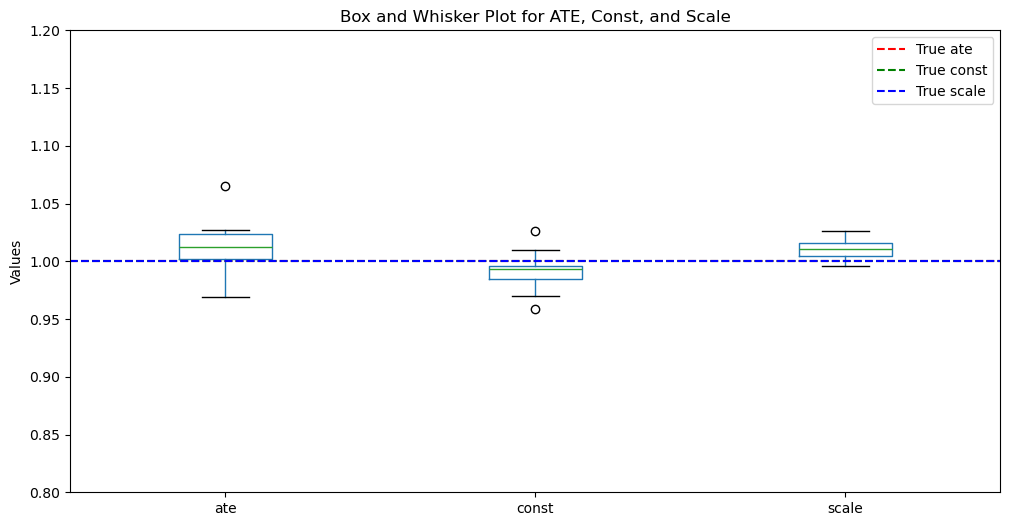

In [7]:
plt.figure(figsize=(12, 6))

# Boxplot
box = gaussian_covariates_results.boxplot(column=["ate", "const", "scale"], grid=False)

# Adding lines for the true parameters
plt.axhline(y=TRUE_PARAMS['ate'], color='r', linestyle='--', label='True ate')
plt.axhline(y=TRUE_PARAMS['const'], color='g', linestyle='--', label='True const')
plt.axhline(y=TRUE_PARAMS['scale'], color='b', linestyle='--', label='True scale')

# Adding title and labels
plt.title('Box and Whisker Plot for ATE, Const, and Scale')
plt.ylabel('Values')
plt.ylim([0.80, 1.20])
plt.legend()

#### Outcome Regression

In [8]:
gaussian_coeffs = {'ate': [], 'const': []}
for i in range(NUM_ITER):
    data = causl_py.generate_gaussian_samples(N=NUM_SAMPLES, causal_params=CAUSAL_PARAMS, seed=i)
    coeff_X, coeff_const = run_outcome_regression(data)
    gaussian_coeffs['ate'].append(coeff_X)
    gaussian_coeffs['const'].append(coeff_const)
gaussian_outcome_coeffs = pd.DataFrame.from_dict(gaussian_coeffs)
gaussian_outcome_coeffs

,ate,const
0,2.031925,0.274835
1,2.020742,0.278772
2,2.041646,0.272939
3,2.018806,0.293595
4,1.989711,0.294193
5,2.051059,0.266681
6,1.990568,0.288492
7,2.007042,0.297439
8,2.023868,0.265236
9,2.069247,0.249396


In [9]:
print(gaussian_outcome_coeffs.mean())
print(gaussian_outcome_coeffs.std())

ate      2.024461
const    0.278158
dtype: float64
ate      0.025320
const    0.015415
dtype: float64


### Mixed Gaussian and Gamma Outcomes

In [10]:
CAUSAL_PARAMS = [1, 1]
SEED = 2
Z_d, Z_c, X, Y = causl_py.generate_mixed_samples(N=10000, causal_params=CAUSAL_PARAMS, seed=SEED).values()

uz_samples = causl_py.generate_uz_samples(Z_cont=Z_c, use_marginal_flow=False)

ff, _ = train_frugal_flow(
    key=jr.PRNGKey(SEED),
    y=Y,
    u_z=uz_samples['uz_cont'],
    condition=X,
    **hyperparams_dict,
    causal_model_args={'ate': 0, 'const': 0, 'scale': 1}
)

causal_margin = ff.bijection.bijections[-1].bijection.bijections[0]

print(causal_margin.ate)
print(causal_margin.const)

  1%|▊                                                                                                | 90/10000 [00:37<1:09:11,  2.39it/s, train=1.3561775020810845, val=1.3842213653920226 (Max patience reached)]

0.9202025122378062
1.1156106192764985


In [11]:
continous_covariates_results = causl_py.run_simulations(
    causl_py.generate_mixed_samples, 
    seed=SEED, 
    num_samples=NUM_SAMPLES, 
    num_iter=NUM_ITER, 
    causal_params=CAUSAL_PARAMS,
    hyperparams_dict=hyperparams_dict,
    causal_model_args={'ate': 0., 'const': 0., 'scale': 1}
)

  1%|█                                                                                               | 114/10000 [00:45<1:06:03,  2.49it/s, train=1.3082076792921682, val=1.4499732349486056 (Max patience reached)]


In [12]:
continous_covariates_results

,ate,const,scale
0,1.096638,0.947515,1.011938
1,1.022328,1.001122,1.009080
2,1.018802,1.001292,1.017639
3,1.044761,0.965521,1.021323
4,1.023655,0.974913,1.008136
5,0.899023,1.056709,0.989286
6,1.032129,0.967260,1.005180
7,1.056637,0.961450,0.989065
8,1.022230,0.994136,1.011406
9,1.072462,0.927897,1.005790


In [13]:
print(continous_covariates_results.mean())
print(continous_covariates_results.std())

ate      1.028866
const    0.979781
scale    1.006884
dtype: float64
ate      0.052284
const    0.035738
scale    0.010582
dtype: float64


#### Outcome Regression

In [14]:
outcome_coeffs = {'ate': [], 'const': []}
for i in range(NUM_ITER):
    data = causl_py.generate_mixed_samples(N=NUM_SAMPLES, causal_params=CAUSAL_PARAMS, seed=i)
    coeff_X, coeff_const = run_outcome_regression(data)
    outcome_coeffs['ate'].append(coeff_X)
    outcome_coeffs['const'].append(coeff_const)
outcome_coeffs = pd.DataFrame.from_dict(outcome_coeffs)
outcome_coeffs

,ate,const
0,1.188531,0.835094
1,1.182430,0.835907
2,1.147205,0.889543
3,1.210747,0.824072
4,1.109217,0.910386
5,1.190407,0.833550
6,1.139697,0.876266
7,1.144484,0.872048
8,1.129973,0.879474
9,1.166694,0.851736


In [15]:
print(outcome_coeffs.mean())
print(outcome_coeffs.std())

ate      1.160938
const    0.860807
dtype: float64
ate      0.031885
const    0.028778
dtype: float64


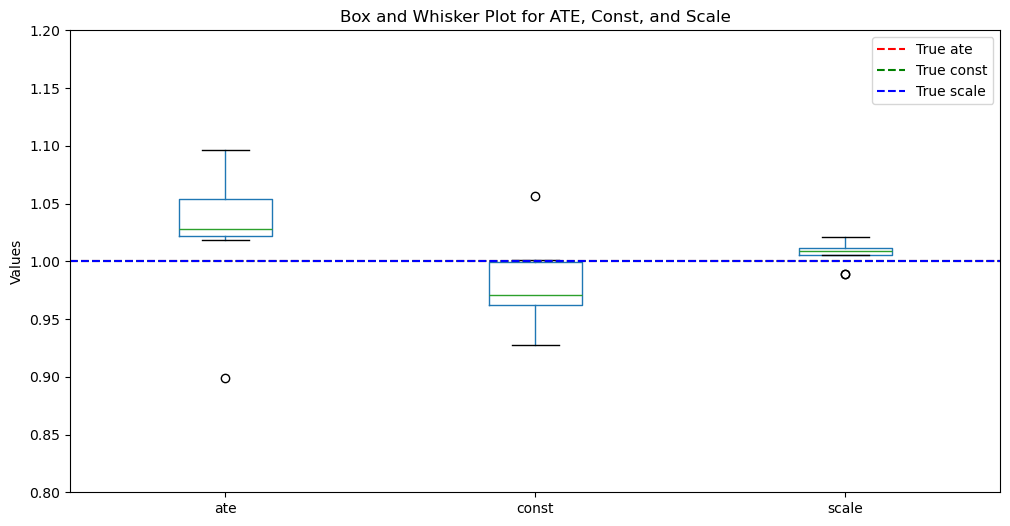

In [16]:
plt.figure(figsize=(12, 6))

# Boxplot
box = continous_covariates_results.boxplot(column=["ate", "const", "scale"], grid=False)

# Adding lines for the true parameters
plt.axhline(y=TRUE_PARAMS['ate'], color='r', linestyle='--', label='True ate')
plt.axhline(y=TRUE_PARAMS['const'], color='g', linestyle='--', label='True const')
plt.axhline(y=TRUE_PARAMS['scale'], color='b', linestyle='--', label='True scale')

# Adding title and labels
plt.title('Box and Whisker Plot for ATE, Const, and Scale')
plt.ylabel('Values')
plt.ylim([0.80, 1.20])
plt.legend()

### Mixed Continuous and Discrete (Small)

In [ ]:
discrete_small_covariates_results = causl_py.run_simulations(
    causl_py.generate_discrete_samples, 
    seed=SEED, 
    num_samples=NUM_SAMPLES, 
    num_iter=NUM_ITER, 
    causal_params=CAUSAL_PARAMS,
    hyperparams_dict=hyperparams_dict,
    causal_model_args={'ate': 0., 'const': 0., 'scale': 1}
)

  0%|                                                                                                                         | 1/10000 [00:02<7:45:54,  2.80s/it, train=2.1450600490000187, val=1.7575859423764526]

In [ ]:
discrete_small_covariates_results

In [ ]:
print(discrete_small_covariates_results.mean())
print(discrete_small_covariates_results.std())

#### Outcome Regression

In [ ]:
outcome_coeffs = {'ate': [], 'const': []}
for i in range(NUM_ITER):
    data = causl_py.generate_discrete_samples(N=NUM_SAMPLES, causal_params=CAUSAL_PARAMS, seed=i)
    coeff_X, coeff_const = run_outcome_regression(data)
    outcome_coeffs['ate'].append(coeff_X)
    outcome_coeffs['const'].append(coeff_const)
outcome_coeffs = pd.DataFrame.from_dict(outcome_coeffs)
outcome_coeffs

In [ ]:
print(outcome_coeffs.mean())
print(outcome_coeffs.std())

In [ ]:
plt.figure(figsize=(12, 6))

# Boxplot
box = discrete_small_covariates_results.boxplot(column=["ate", "const", "scale"], grid=False)

# Adding lines for the true parameters
plt.axhline(y=TRUE_PARAMS['ate'], color='r', linestyle='--', label='True ate')
plt.axhline(y=TRUE_PARAMS['const'], color='g', linestyle='--', label='True const')
plt.axhline(y=TRUE_PARAMS['scale'], color='b', linestyle='--', label='True scale')

# Adding title and labels
plt.title('Box and Whisker Plot for ATE, Const, and Scale')
plt.ylabel('Values')
plt.ylim([0.80, 1.20])
plt.legend()

### Mixed Continuous and Discrete (Large)

In [ ]:
discrete_big_covariates_results = causl_py.run_simulations(
    causl_py.generate_many_discrete_samples, 
    seed=SEED, 
    num_samples=NUM_SAMPLES, 
    num_iter=NUM_ITER, 
    causal_params=CAUSAL_PARAMS,
    hyperparams_dict=hyperparams_dict,
    causal_model_args={'ate': 0., 'const': 0., 'scale': 1}
)

In [ ]:
discrete_big_covariates_results

In [ ]:
print(discrete_big_covariates_results.mean())
print(discrete_big_covariates_results.std())

#### Outcome Regression

In [ ]:
outcome_coeffs = {'ate': [], 'const': []}
for i in range(NUM_ITER):
    data = causl_py.generate_many_discrete_samples(N=NUM_SAMPLES, causal_params=CAUSAL_PARAMS, seed=i)
    coeff_X, coeff_const = run_outcome_regression(data)
    outcome_coeffs['ate'].append(coeff_X)
    outcome_coeffs['const'].append(coeff_const)
outcome_coeffs = pd.DataFrame.from_dict(outcome_coeffs)
outcome_coeffs

In [ ]:
print(outcome_coeffs.mean())
print(outcome_coeffs.std())

In [ ]:
plt.figure(figsize=(12, 6))

# Boxplot
box = discrete_big_covariates_results.boxplot(column=["ate", "const", "scale"], grid=False)

# Adding lines for the true parameters
plt.axhline(y=TRUE_PARAMS['ate'], color='r', linestyle='--', label='True ate')
plt.axhline(y=TRUE_PARAMS['const'], color='g', linestyle='--', label='True const')
plt.axhline(y=TRUE_PARAMS['scale'], color='b', linestyle='--', label='True scale')

# Adding title and labels
plt.title('Box and Whisker Plot for ATE, Const, and Scale')
plt.ylabel('Values')
plt.ylim([0.80, 1.20])
plt.legend()

### Mixed Continuous and Discrete (Large and Sparse)

In [ ]:
discrete_sparse_covariates_results = causl_py.run_simulations(
    causl_py.generate_many_discrete_samples_sparse, 
    seed=SEED, 
    num_samples=NUM_SAMPLES, 
    num_iter=NUM_ITER, 
    causal_params=CAUSAL_PARAMS,
    hyperparams_dict=hyperparams_dict,
    causal_model_args={'ate': 0., 'const': 0., 'scale': 1}
)

In [ ]:
discrete_sparse_covariates_results

In [ ]:
print(discrete_sparse_covariates_results.mean())
print(discrete_sparse_covariates_results.std())

#### Outcome Regression

In [ ]:
outcome_coeffs = {'ate': [], 'const': []}
for i in range(NUM_ITER):
    data = causl_py.generate_many_discrete_samples(N=NUM_SAMPLES, causal_params=CAUSAL_PARAMS, seed=i)
    coeff_X, coeff_const = run_outcome_regression(data)
    outcome_coeffs['ate'].append(coeff_X)
    outcome_coeffs['const'].append(coeff_const)
outcome_coeffs = pd.DataFrame.from_dict(outcome_coeffs)
outcome_coeffs

In [ ]:
plt.figure(figsize=(12, 6))

# Boxplot
box = discrete_sparse_covariates_results.boxplot(column=["ate", "const", "scale"], grid=False)

# Adding lines for the true parameters
plt.axhline(y=TRUE_PARAMS['ate'], color='r', linestyle='--', label='True ate')
plt.axhline(y=TRUE_PARAMS['const'], color='g', linestyle='--', label='True const')
plt.axhline(y=TRUE_PARAMS['scale'], color='b', linestyle='--', label='True scale')

# Adding title and labels
plt.title('Box and Whisker Plot for ATE, Const, and Scale')
plt.ylabel('Values')
plt.ylim([0.80, 1.20])
plt.legend()